# Preliminary Feature-KD Experiments Analysis

In [8]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode()
import plotly.io as pio
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
import math
import re
import os
import seaborn as sns
plt.rcParams['figure.dpi'] = 250

from typing import List, Tuple, Optional, Literal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
SAMPLING_TECHNIQUES_NAMES = {
    0: 'NO',
    1: 'RANDOM WEIGHTED',
    2: 'SUBGROUP',
}


FAIRNESS_CONSTRAINTS_NAMES = {
    1: 'EQUAL LOSS',
    2: 'EQUALIZED ODDS',
}


def get_subgroup_names(
    metric,
):
    if 'gap' in metric:
        return {
            f'age_{metric}': f'Age',
            f'sex_{metric}': f'Sex',
            f'race_{metric}': f'Race',
        }
    else:
        return {
            f'age_{metric}_group_0': f'Age < 60',
            f'age_{metric}_group_1': f'Age 60+',
            f'sex_{metric}_group_0': f'Male',
            f'sex_{metric}_group_1': f'Female',
            f'race_{metric}_group_0': f'White',
            f'race_{metric}_group_1': f'Non-White',
        }
    

## Read Data

In [21]:
def read_data(path, teacher_id=None):
    test_data = []
    for folder in os.scandir(path):
        if teacher_id is not None:
            if folder.is_dir() and teacher_id in folder.name:
                # Perform operations on the folder
                file_path = path + folder.name
                if os.path.exists(file_path + '/test.csv'):
                    df_tmp = pd.read_csv(file_path + '/test.csv')
                    test_data.append(df_tmp)
        else:
            if folder.is_dir():
                # Perform operations on the folder
                file_path = path + folder.name
                if os.path.exists(file_path + '/test.csv'):
                    df_tmp = pd.read_csv(file_path + '/test.csv')
                    test_data.append(df_tmp)

    df = pd.concat(test_data)
    df['auc_gap_relative'] = df['auc_gap'] / df['auc']
    df['age_auc'] = (df['age_auc_group_0'] + df['age_auc_group_1']) / 2
    df['sex_auc'] = (df['sex_auc_group_0'] + df['sex_auc_group_1']) / 2
    df['age_auc_gap'] = abs(df['age_auc_group_0'] - df['age_auc_group_1'])
    df['sex_auc_gap'] = abs(df['sex_auc_group_0'] - df['sex_auc_group_1'])
    df['avg_auc_gap'] = (df['age_auc_gap'] + df['sex_auc_gap']) / 2
    df['age_auc_gap_relative'] = df['age_auc_gap'] / df['auc']
    df['sex_auc_gap_relative'] = df['sex_auc_gap'] / df['auc']
    df['avg_auc_gap_relative'] = df['avg_auc_gap'] / df['auc']
    return df


## Original -> Baseline
original_df = read_data('../../results/ham10000/resnet/original/')
vanilla_kd = read_data('../../results/ham10000/kd/vanilla/', 'r50-sam1-s44')
attention_kd = read_data('../../results/ham10000/kd/attention/ce_mse_kl/', 'r50-sam1-s44')

## Feature KD on Original HAM10k
feature_kd_ham10k = read_data('../../results/ham10000/kd/feature/preliminary/', 'r50-sam1-s44')
feature_kd_ham10k['feature_maps'] = feature_kd_ham10k['model_id'].str.extract(r'fm(\d+)')

## Feature KD on Original HAM10k
feature_kd_ham10k_rgb = read_data('../../results/ham10000/kd/feature/preliminary_rgb/', 'r50-sam1-s44')
feature_kd_ham10k_rgb['feature_maps'] = feature_kd_ham10k_rgb['model_id'].str.extract(r'fm(\d+)')

## Feature KD on Skewed Data
# No Female
no_female_feature = read_data('../../results/ham10000_no_female/kd-feature/', 'r34-sam1-s46')
no_female_feature['feature_maps'] = no_female_feature['model_id'].str.extract(r'fm(\d+)')
no_female_vanilla = read_data('../../results/ham10000_no_female/kd/', 'r34-sam1-s46')
no_female_baseline = read_data('../../results/ham10000_no_female/resnet/')

# No Old
no_old_feature = read_data('../../results/ham10000_no_old/kd-feature/', 'r34-sam1-s46')
no_old_feature['feature_maps'] = no_old_feature['model_id'].str.extract(r'fm(\d+)')
no_old_vanilla = read_data('../../results/ham10000_no_old/kd/', 'r34-sam1-s46')
no_old_baseline = read_data('../../results/ham10000_no_old/resnet/')

# No Female RGB
no_female_feature_rgb = read_data('../../results/ham10000_no_female/kd-feature_rgb/', 'r34-sam1-s46')
no_female_feature_rgb['feature_maps'] = no_female_feature_rgb['model_id'].str.extract(r'fm(\d+)')
# No Old RHB
no_old_feature_rgb = read_data('../../results/ham10000_no_old/kd-feature_rgb/', 'r34-sam1-s46')
no_old_feature_rgb['feature_maps'] = no_old_feature_rgb['model_id'].str.extract(r'fm(\d+)')

# No Female CE+MSE+KL Loss
no_female_ce_mse_kl = read_data('../../results/ham10000_no_female/kd-feature_kl_loss/', 'r34-sam1-s46')
no_female_ce_mse_kl['feature_maps'] = no_female_ce_mse_kl['model_id'].str.extract(r'fm(\d+)')

# No Old CE+MSE+KL Loss
no_old_ce_mse_kl = read_data('../../results/ham10000_no_old/kd-feature_kl_loss/', 'r34-sam1-s46')
no_old_ce_mse_kl['feature_maps'] = no_old_ce_mse_kl['model_id'].str.extract(r'fm(\d+)')

## Feature KD on Original HAM10k but CE + MSE + KL Loss
ce_mse_kl = read_data('../../results/ham10000/kd/feature/ce_mse_kl/', 'r50-sam1-s44')
ce_mse_kl['feature_maps'] = ce_mse_kl['model_id'].str.extract(r'fm(\d+)')

ce_mse_kl_2 = read_data('../../results/ham10000/kd/feature/ce_mse_kl_2/', 'r50-sam1-s44')
ce_mse_kl_2['feature_maps'] = ce_mse_kl_2['model_id'].str.extract(r'fm(\d+)')

equal_mse_ce = read_data('../../results/ham10000/kd/feature/equal_mse_ce/', 'r50-sam1-s44')
equal_mse_ce['feature_maps'] = equal_mse_ce['model_id'].str.extract(r'fm(\d+)')

equal_no_female = read_data('../../results/ham10000_no_female/kd-feature_equal_loss/', 'r34-sam1-s46')
equal_no_female['feature_maps'] = equal_no_female['model_id'].str.extract(r'fm(\d+)')

equal_no_old = read_data('../../results/ham10000_no_old/kd-feature_equal_loss/', 'r34-sam1-s46')
equal_no_old['feature_maps'] = equal_no_old['model_id'].str.extract(r'fm(\d+)')


## Analysis
- feature_kd_ham10k
- original_df

### Table Performance

In [22]:
def kd_table_performance(
        resnet_df: pd.DataFrame,
        kd_df: pd.DataFrame,
        teacher_df: pd.DataFrame,
        teacher_id: str,
        metric: str,
        title: str = '',
        bar_width=0.5, 
        line_length=0.05,
    ):

    kd_df = kd_df.sort_values(by=['model_name'])
    teacher_performance = teacher_df[teacher_df['model_id'] == teacher_id][metric]

    scores = resnet_df[metric]
    mean_score = scores.mean()
    std_error = scores.std()

    kd_scores = kd_df[metric]
    kd_mean_score = kd_scores.mean()
    kd_std_error = kd_scores.std()

    auc_change = kd_mean_score - mean_score
    teacher_diff = teacher_performance[0] - kd_mean_score 

    print(f'mean: {kd_mean_score:.3f}')
    print(f'std: {kd_std_error:.3f}')
    print(f'auc change: {auc_change:.3f}')
    print(f'teacher difference: {teacher_diff:.3f}')

In [23]:
fm1111_df = feature_kd_ham10k[feature_kd_ham10k['feature_maps'] == '1111']
fm0101_df = feature_kd_ham10k[feature_kd_ham10k['feature_maps'] == '0101']

print('Ham10k CE (0.2), MSE (0.8) FM1111')

kd_table_performance(
    original_df,
    fm1111_df,
    original_df,
    'r50-sam1-s44',
    'auc',
)

print('Ham10k CE (0.2), MSE (0.8) FM0101')

kd_table_performance(
    original_df,
    fm0101_df,
    original_df,
    'r50-sam1-s44',
    'auc',
)


print('Ham10k Equal Loss MSE CE FM1111')

equal_fm1111 = equal_mse_ce[equal_mse_ce['feature_maps'] == '1111']
equal_fm0101 = equal_mse_ce[equal_mse_ce['feature_maps'] == '0101']

kd_table_performance(
    original_df,
    equal_fm1111,
    original_df,
    'r50-sam1-s44',
    'auc',
    title='KD on Ham10k Original Data 1111 FM Equal Loss MSE CE',
)

print('Ham10k Equal Loss MSE CE FM0101')

kd_table_performance(
    original_df,
    equal_fm0101,
    original_df,
    'r50-sam1-s44',
    'auc',
    title='KD on Ham10k Original Data 0101 FM Equal Loss MSE CE',
)

ce_mse_kl_1111 = ce_mse_kl[ce_mse_kl['feature_maps'] == '1111']
ce_mse_kl_0101 = ce_mse_kl[ce_mse_kl['feature_maps'] == '0101']

print('Ham10k Original Data CE+MSE+KL Loss fm1111 0.2, 0.4, 0.4')

kd_table_performance(
    original_df,
    ce_mse_kl_1111,
    original_df,
    'r50-sam1-s44',
    'auc',
    title='CE+MSE+KL Loss with 0.2, 0.4, 0.4 weighting and 1111 FM',
)

print('Ham10k Original Data CE+MSE+KL Loss fm0101 with 0.2, 0.4, 0.4')

kd_table_performance(
    original_df,
    ce_mse_kl_0101,
    original_df,
    'r50-sam1-s44',
    'auc',
    title='CE+MSE+KL Loss with 0.2, 0.4, 0.4 weighting and 0101 FM',
)


ce_mse_kl_2_1111 = ce_mse_kl_2[ce_mse_kl_2['feature_maps'] == '1111']
ce_mse_kl_2_0101 = ce_mse_kl_2[ce_mse_kl_2['feature_maps'] == '0101']
ce_mse_kl_2_0010 = ce_mse_kl_2[ce_mse_kl_2['feature_maps'] == '0010']
ce_mse_kl_2_0100 = ce_mse_kl_2[ce_mse_kl_2['feature_maps'] == '0100']

print('Ham10k Original Data CE+MSE+KL Loss with 0.2, 0.6, 0.2 fm1111')

kd_table_performance(
    original_df,
    ce_mse_kl_2_1111,
    original_df,
    'r50-sam1-s44',
    'auc',
    title='CE+MSE+KL Loss with 0.2, 0.6, 0.2 weighting and 1111 FM',
)

print('Ham10k Original Data CE+MSE+KL Loss with 0.2, 0.6, 0.2 fm0101')

kd_table_performance(
    original_df,
    ce_mse_kl_2_0101,
    original_df,
    'r50-sam1-s44',
    'auc',
    title='CE+MSE+KL Loss with 0.2, 0.6, 0.2 weighting and 0101 FM',
)

print('Vanilla KD')

kd_table_performance(
    original_df,
    vanilla_kd,
    original_df,
    'r50-sam1-s44',
    'auc',
    title='Vanilla KD',
)

print('Attention KD')

kd_table_performance(
    original_df,
    attention_kd,
    original_df,
    'r50-sam1-s44',
    'auc',
    title='Attention KD',
)

Ham10k CE (0.2), MSE (0.8) FM1111
mean: 0.885
std: 0.005
auc change: -0.003
teacher difference: 0.023
Ham10k CE (0.2), MSE (0.8) FM0101
mean: 0.888
std: 0.016
auc change: -0.001
teacher difference: 0.020
Ham10k Equal Loss MSE CE FM1111
mean: 0.892
std: 0.008
auc change: 0.004
teacher difference: 0.015
Ham10k Equal Loss MSE CE FM0101
mean: 0.890
std: 0.010
auc change: 0.001
teacher difference: 0.018
Ham10k Original Data CE+MSE+KL Loss fm1111 0.2, 0.4, 0.4
mean: 0.906
std: 0.004
auc change: 0.017
teacher difference: 0.002
Ham10k Original Data CE+MSE+KL Loss fm0101 with 0.2, 0.4, 0.4
mean: 0.907
std: 0.003
auc change: 0.019
teacher difference: 0.001
Ham10k Original Data CE+MSE+KL Loss with 0.2, 0.6, 0.2 fm1111
mean: 0.906
std: 0.006
auc change: 0.018
teacher difference: 0.001
Ham10k Original Data CE+MSE+KL Loss with 0.2, 0.6, 0.2 fm0101
mean: 0.908
std: 0.006
auc change: 0.019
teacher difference: -0.000
Vanilla KD
mean: 0.903
std: 0.004
auc change: 0.014
teacher difference: 0.005
Attentio

### Overall Performance

In [38]:
def kd_overall_model_performance(
        resnet_df: pd.DataFrame,
        kd_df: pd.DataFrame,
        teacher_df: pd.DataFrame,
        teacher_id: str,
        metric: str,
        title: str = '',
        bar_width=0.5, 
        line_length=0.05,
        legend=True,
    ):

    kd_df = kd_df.sort_values(by=['model_name'])
    # Get teachers from resnet_df
    teacher_performance = teacher_df[teacher_df['model_id'] == teacher_id][metric]
                            
    # Set up graphical variables
    total_bars = 2 # TODO: Change maybe
    bar_group_width = bar_width * total_bars
    legend_handles = []
    legend_labels = []

    # Set up the plot
    fig, ax = plt.subplots(figsize=(7, 6))

    # Create the plot
    for i, model in enumerate(kd_df['model_name'].unique()):
        model_scores = []

        # Get without KD
        scores = resnet_df[(resnet_df['model_name'] == model)][metric]
        mean_score = scores.mean()
        std_error = scores.std()
        model_scores.append(mean_score)
        x_pos_no_kd = i - bar_group_width/2 + (0 + 0.5) * bar_width
        handle_no_kd = ax.errorbar(x_pos_no_kd, mean_score, yerr=std_error, marker='D', capsize=5, markersize=14, markerfacecolor='blue', markeredgecolor='black', ecolor='gray', linewidth=0.9)
        if 'Performance\nw/o KD' not in legend_labels:
            legend_handles.append(handle_no_kd)
            legend_labels.append('Performance\nw/o KD')

        # Get with KD
        scores = kd_df[(kd_df['model_name'] == model)][metric]
        mean_score = scores.mean()
        std_error = scores.std()
        model_scores.append(mean_score)
        print(mean_score, std_error)
        x_pos_kd = i - bar_group_width/2 + (1 + 0.5) * bar_width
        handle_kd = ax.errorbar(x_pos_kd, mean_score, yerr=std_error, marker='o', capsize=5, markersize=14, markerfacecolor='orange', markeredgecolor='black', ecolor='gray', linewidth=0.9)
        if 'Performance\nw/ KD' not in legend_labels:
            legend_handles.append(handle_kd)
            legend_labels.append('Performance\nw/ KD')

        # Draw a dotted line between No KD and KD
        ax.plot([x_pos_no_kd, x_pos_kd], [model_scores[0], model_scores[1]], linestyle=':', color='grey')


    # Show Teacher performance:
    teacher = ax.axhline(y=teacher_performance[0], linestyle='-', label='Teacher', linewidth=0.9, zorder=1, color='red')
    legend_handles.append(teacher)
    legend_labels.append('Teacher\nPerformance')
    # Add text above the teacher performance line
    # ax.text(-0.45, teacher_performance[0], 'Teacher Performance', color='black', va='bottom', fontsize=15)

    # Customize the plot
    ax.set_xticks(np.arange(len(kd_df['model_name'].unique())))
    ax.set_xticklabels(kd_df['model_name'].unique(), fontsize=18)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_ylabel(metric, fontsize=18) 
    # Set the x-axis limits to show all the error bars
    ax.set_xlim(-bar_group_width/2, len(kd_df['model_name'].unique())-1+bar_group_width/2)
    current_ylim = ax.get_ylim()
    ax.set_ylim(current_ylim[0], 0.913)      
    ax.set_facecolor('#F0F0F0')
    # Legend
    if legend:
        legend = ax.legend(handles=legend_handles, labels=legend_labels, loc='lower right', handlelength=3.0, handletextpad=0.5, prop={'size': 12})
        # legend = ax.legend(handles=legend_handles, labels=legend_labels, bbox_to_anchor=(1.02, 1.02), loc='upper left', handlelength=3.0, handletextpad=0.5, prop={'size': 15})
        # legend.get_frame().set_alpha(1)
        # legend.get_frame().set_facecolor('#F0F0F0')
        # legend.get_frame().set_edgecolor('black')
    # Grid
    ax.yaxis.grid(True, linestyle='dotted', linewidth=0.8, color='white', alpha=1)
    # Title
    fig.suptitle(title, fontsize=18, y=0.93)
    plt.show()
    return fig, ax
    

0.9081246907471549 0.003597094482161341
0.9060696025070097 0.0021201266806691764


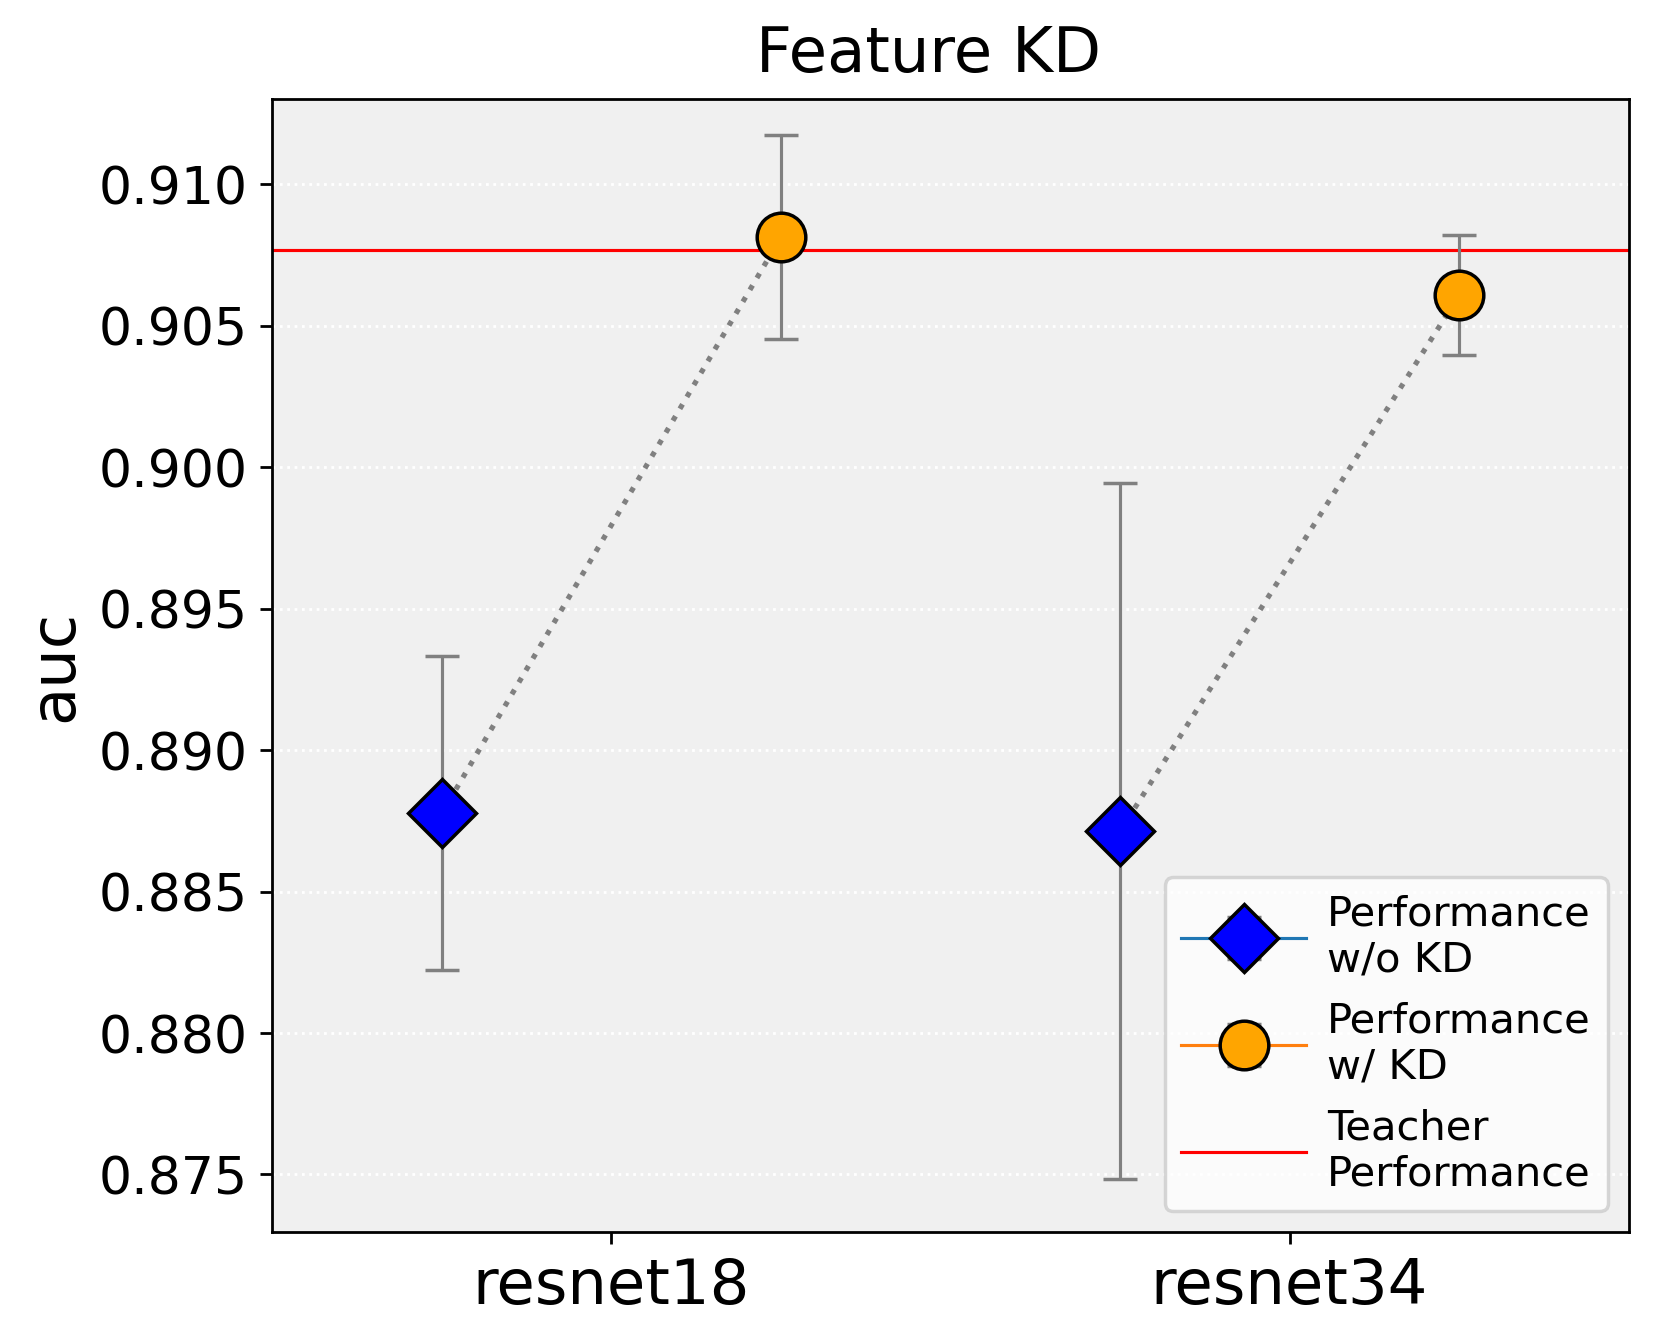

0.9015592952282105 0.004803267797819852
0.9040485663215294 0.003806664535902657


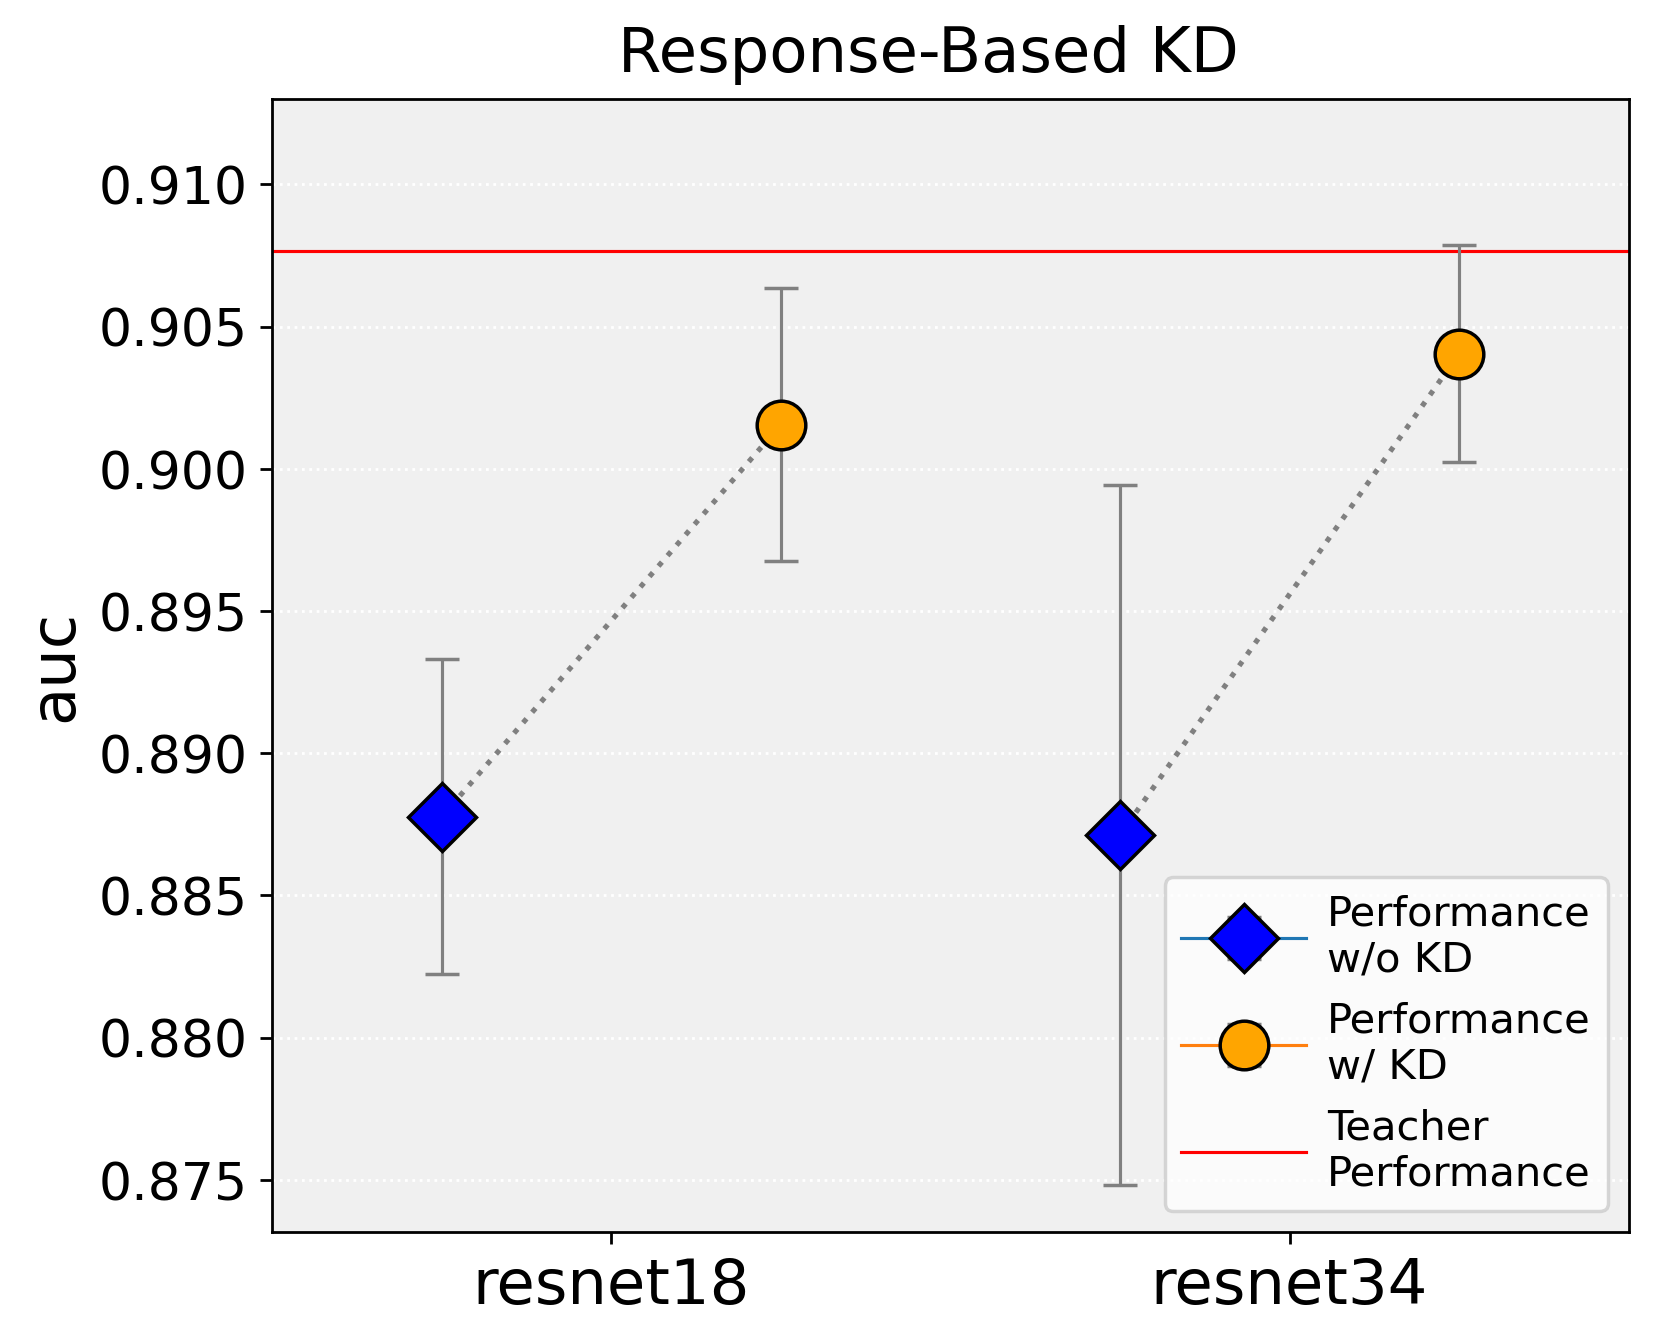

0.9073351949324964 0.0040539805432420655
0.9070946697308919 0.005736049278352439


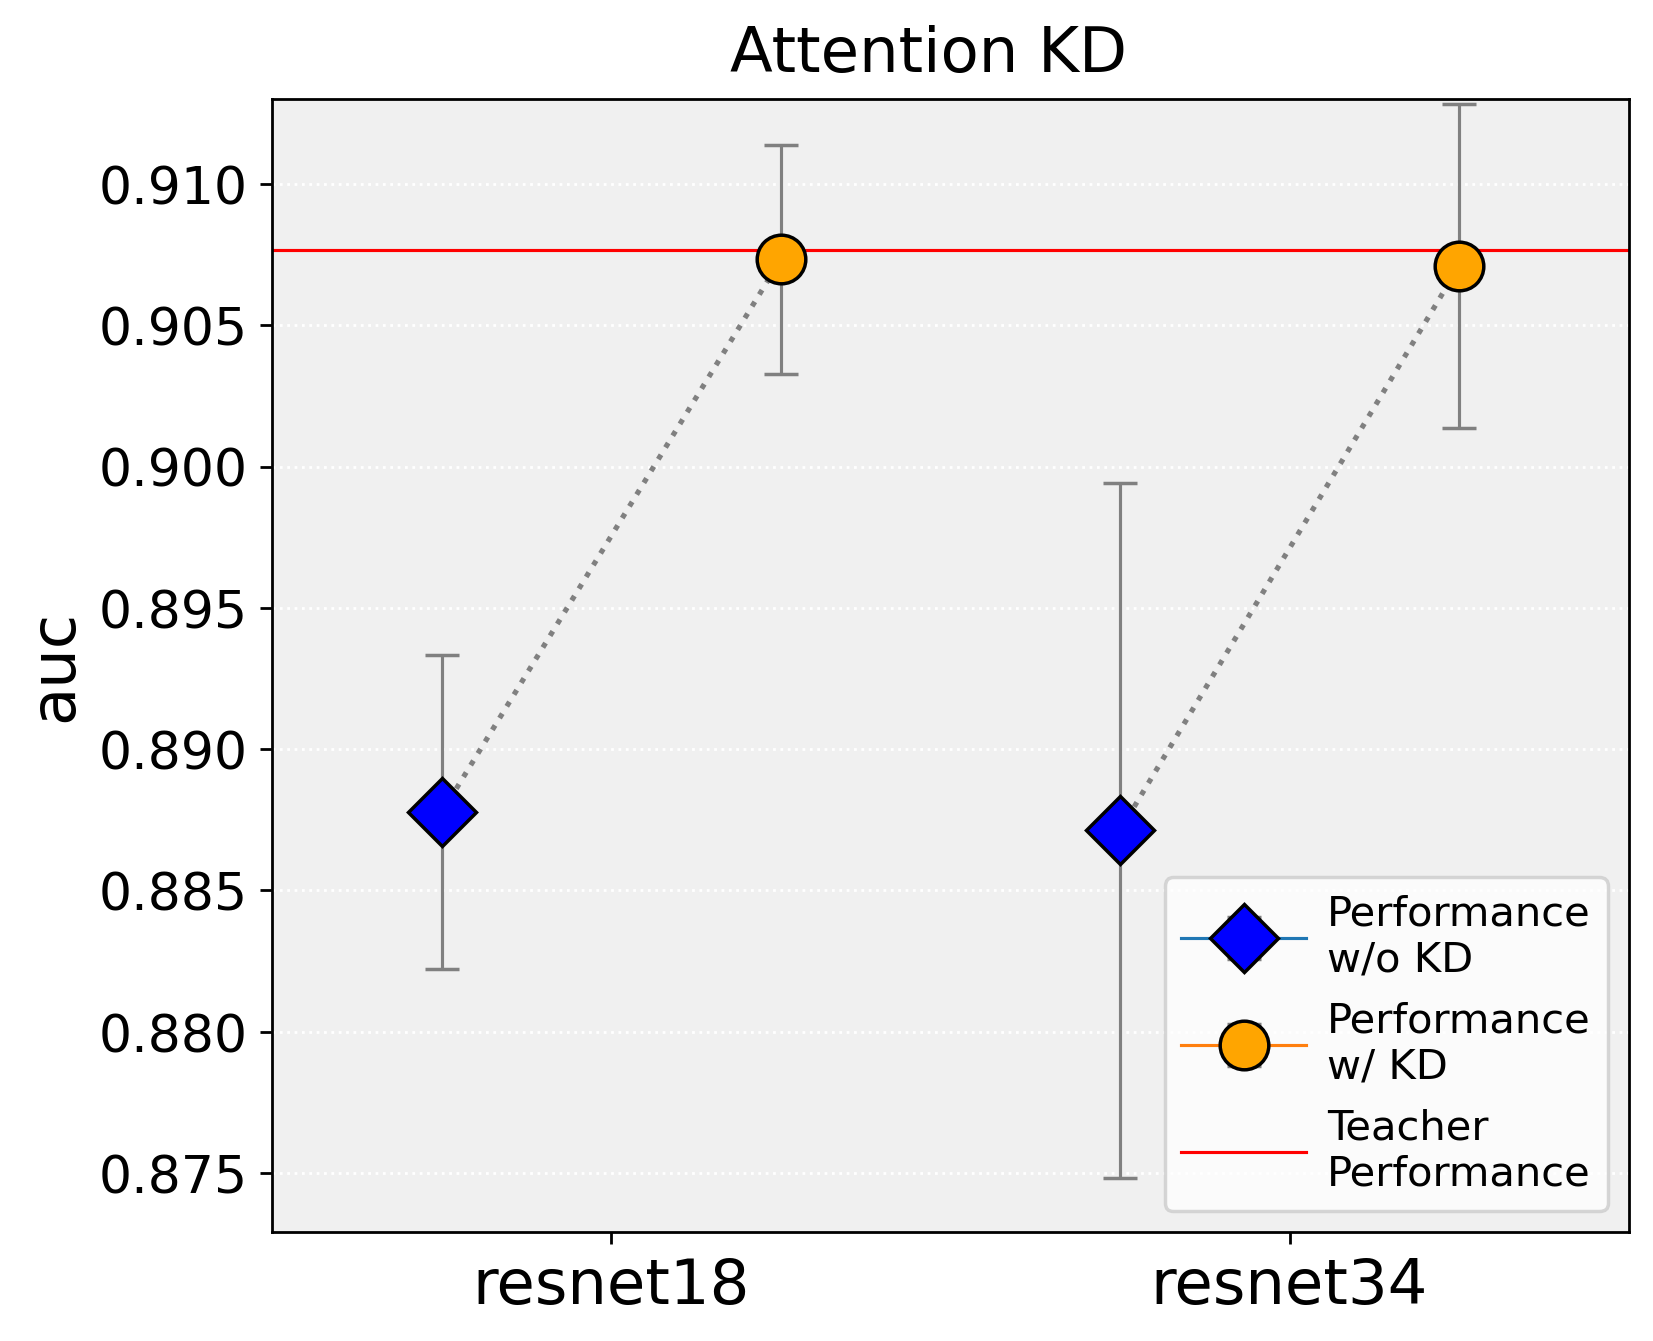

(<Figure size 1750x1500 with 1 Axes>, <Axes: ylabel='auc'>)

In [39]:
ce_mse_kl_0101 = ce_mse_kl[ce_mse_kl['feature_maps'] == '0101']

kd_overall_model_performance(
    original_df,
    ce_mse_kl_0101,
    original_df,
    'r50-sam1-s44',
    'auc',
    # title='CE+MSE+KL Loss with 0.2, 0.4, 0.4 weighting and 0101 FM',
    title='Feature KD',
)


kd_overall_model_performance(
    original_df,
    vanilla_kd,
    original_df,
    'r50-sam1-s44',
    'auc',
    title='Response-Based KD',
    legend=True,
)

kd_overall_model_performance(
    original_df,
    attention_kd,
    original_df,
    'r50-sam1-s44',
    'auc',
    title='Attention KD',
    legend=True,
)

In [106]:
from PIL import Image

def combine_images(img_path1, img_path2, output_path):
    # Open the images
    img1 = Image.open(img_path1)
    img2 = Image.open(img_path2)

    # Ensure the images have the same height. If not, you might want to resize.
    if img1.size[1] != img2.size[1]:
        raise ValueError("Images do not have the same height!")

    # Determine the size of the combined image
    total_width = img1.size[0] + img2.size[0]
    max_height = max(img1.size[1], img2.size[1])

    # Create an empty image with the determined size and 'RGBA' mode for transparency
    new_img = Image.new('RGBA', (total_width, max_height))

    # Paste the images side by side on the new image. Use the image itself as the mask to preserve transparency.
    new_img.paste(img1, (0, 0), img1)
    new_img.paste(img2, (img1.size[0], 0), img2)

    # Save the combined image
    new_img.save(output_path)

# Example usage:
combine_images('../../response_kd.png', '../../feature_kd.png', 'combined_image.png')


In [ ]:


fm1111_df = feature_kd_ham10k[feature_kd_ham10k['feature_maps'] == '1111']
fm0101_df = feature_kd_ham10k[feature_kd_ham10k['feature_maps'] == '0101']

print('Ham10k Original Data')

kd_overall_model_performance(
    original_df,
    fm1111_df,
    original_df,
    'r50-sam1-s44',
    'auc',
    title='KD on Ham10k Original Data 1111 FM',
)

kd_overall_model_performance(
    original_df,
    fm0101_df,
    original_df,
    'r50-sam1-s44',
    'auc',
    title='KD on Ham10k Original Data 0101 FM',
)

kd_overall_model_performance(
    original_df,
    feature_kd_ham10k_rgb,
    original_df,
    'r50-sam1-s44',
    'auc',
    title='KD on Ham10k Original Data 0101 FM (RGB)',
)

print('Ham10k Equal Loss MSE CE')

equal_fm1111 = equal_mse_ce[equal_mse_ce['feature_maps'] == '1111']
equal_fm0101 = equal_mse_ce[equal_mse_ce['feature_maps'] == '0101']

kd_overall_model_performance(
    original_df,
    equal_mse_ce,
    original_df,
    'r50-sam1-s44',
    'auc',
    title='KD on Ham10k Original Data 0101 FM Equal Loss MSE CE',
)

kd_overall_model_performance(
    no_female_baseline,
    equal_no_female,
    original_df,
    'r34-sam1-s46',
    'auc',
    title='No FEMALE 0101 FM Equal Loss MSE CE',
)

kd_overall_model_performance(
    no_female_baseline,
    equal_no_old,
    original_df,
    'r34-sam1-s46',
    'auc',
    title='No OLD 0101 FM Equal Loss MSE CE',
)





print('Ham10k Skewed Data')
no_female_feature_1111 = no_female_feature[no_female_feature['feature_maps'] == '1111']
no_female_feature_0101 = no_female_feature[no_female_feature['feature_maps'] == '0101']
no_old_feature_1111 = no_old_feature[no_old_feature['feature_maps'] == '1111']
no_old_feature_0101 = no_old_feature[no_old_feature['feature_maps'] == '0101']

kd_overall_model_performance(
    no_female_baseline,
    no_female_feature_1111,
    original_df,
    'r34-sam1-s46',
    'auc',
    title='No FEMALE 1111 FM',
)

kd_overall_model_performance(
    no_female_baseline,
    no_female_feature_0101,
    original_df,
    'r34-sam1-s46',
    'auc',
    title='No FEMALE 0101 FM',
)

kd_overall_model_performance(
    no_female_baseline,
    no_female_feature_rgb,
    original_df,
    'r34-sam1-s46',
    'auc',
    title='No FEMALE 0101 FM RGB',
)

kd_overall_model_performance(
    no_old_baseline,
    no_old_feature_1111,
    original_df,
    'r34-sam1-s46',
    'auc',
    title='No OLD 1111 FM',
)

kd_overall_model_performance(
    no_old_baseline,
    no_old_feature_0101,
    original_df,
    'r34-sam1-s46',
    'auc',
    title='No OLD 0101 FM',
)

kd_overall_model_performance(
    no_old_baseline,
    no_old_feature_rgb,
    original_df,
    'r34-sam1-s46',
    'auc',
    title='No OLD 0101 FM RGB',
)

print('Ham10k Skewed Data CE+MSE+KL Loss')
no_female_ce_mse_kl_0101 = no_female_ce_mse_kl[no_female_ce_mse_kl['feature_maps'] == '0101']
no_old_ce_mse_kl_0101 = no_old_ce_mse_kl[no_old_ce_mse_kl['feature_maps'] == '0101']


kd_overall_model_performance(
    no_female_baseline,
    no_female_ce_mse_kl_0101,
    original_df,
    'r34-sam1-s46',
    'auc',
    title='No FEMALE 0101 FM with CE+MSE+KL Loss',
)

kd_overall_model_performance(
    no_old_baseline,
    no_old_ce_mse_kl_0101,
    original_df,
    'r34-sam1-s46',
    'auc',
    title='No OLD 0101 FM with CE+MSE+KL Loss',
)


print('Ham10k Original Data CE+MSE+KL Loss')

ce_mse_kl_1111 = ce_mse_kl[ce_mse_kl['feature_maps'] == '1111']
ce_mse_kl_0101 = ce_mse_kl[ce_mse_kl['feature_maps'] == '0101']


kd_overall_model_performance(
    original_df,
    ce_mse_kl_1111,
    original_df,
    'r50-sam1-s44',
    'auc',
    title='CE+MSE+KL Loss with 0.2, 0.4, 0.4 weighting and 1111 FM',
)

kd_overall_model_performance(
    original_df,
    ce_mse_kl_0101,
    original_df,
    'r50-sam1-s44',
    'auc',
    # title='CE+MSE+KL Loss with 0.2, 0.4, 0.4 weighting and 0101 FM',
    title='Feature-Based KD',
)


print('Ham10k Original Data CE+MSE+KL Loss with different weighting')

ce_mse_kl_2_1111 = ce_mse_kl_2[ce_mse_kl_2['feature_maps'] == '1111']
ce_mse_kl_2_0101 = ce_mse_kl_2[ce_mse_kl_2['feature_maps'] == '0101']
ce_mse_kl_2_0010 = ce_mse_kl_2[ce_mse_kl_2['feature_maps'] == '0010']
ce_mse_kl_2_0100 = ce_mse_kl_2[ce_mse_kl_2['feature_maps'] == '0100']


kd_overall_model_performance(
    original_df,
    ce_mse_kl_2_1111,
    original_df,
    'r50-sam1-s44',
    'auc',
    title='CE+MSE+KL Loss with 0.2, 0.6, 0.2 weighting and 1111 FM',
)

kd_overall_model_performance(
    original_df,
    ce_mse_kl_2_0101,
    original_df,
    'r50-sam1-s44',
    'auc',
    title='CE+MSE+KL Loss with 0.2, 0.6, 0.2 weighting and 0101 FM',
)

kd_overall_model_performance(
    original_df,
    ce_mse_kl_2_0010,
    original_df,
    'r50-sam1-s44',
    'auc',
    title='CE+MSE+KL Loss with 0.2, 0.6, 0.2 weighting and 0010 FM',
)

kd_overall_model_performance(
    original_df,
    ce_mse_kl_2_0100,
    original_df,
    'r50-sam1-s44',
    'auc',
    title='CE+MSE+KL Loss with 0.2, 0.6, 0.2 weighting and 0100 FM',
)


### Subgroup Disparities

In [6]:
experiment_colors = {
    "sex_no_kd": "violet",
    "age_no_kd": "gold",
    "sex_kd": "darkviolet",
    "age_kd": "orange",
}


def kd_overall_model_subgroup_performance(
        resnet_df: pd.DataFrame,
        kd_df: pd.DataFrame,
        teacher_df: pd.DataFrame,
        subgroups: list[str],
        teacher_id: str,
        metric: str,
        title: str = '',
        bar_width=0.5, 
        line_length=0.05,
    ):

    kd_df = kd_df.sort_values(by=['model_name'])

    age_metric = 'age_' + metric
    sex_metric = 'sex_' + metric

    # Get teachers from resnet_df
    age_teacher_performance = teacher_df[teacher_df['model_id'] == teacher_id][age_metric][0]
    sex_teacher_performance = teacher_df[teacher_df['model_id'] == teacher_id][sex_metric][0]
                            
    # Set up graphical variables
    total_bars = 2 # TODO: Change maybe
    bar_group_width = bar_width * total_bars
    legend_handles = []
    legend_labels = []

    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create the plot
    for i, model in enumerate(kd_df['model_name'].unique()):
        for j, subgroup in enumerate(subgroups):
            model_scores = []
            subgroup_metric = subgroup + "_" + metric

            # Get without KD
            scores = resnet_df[(resnet_df['model_name'] == model)][subgroup_metric]
            mean_score = scores.mean()
            std_error = scores.std()
            model_scores.append(mean_score)
            x_pos_no_kd = i - bar_group_width/2 + (0 + 0.5) * bar_width
            handle_no_kd = ax.errorbar(x_pos_no_kd, mean_score, yerr=std_error, marker='D', capsize=5, markersize=12, markerfacecolor=experiment_colors[f'{subgroup}_no_kd'], markeredgecolor='black', ecolor='gray', linewidth=0.9)


            if f'{subgroup.capitalize()} no KD' not in legend_labels:
                legend_handles.append(handle_no_kd)
                legend_labels.append(f'{subgroup.capitalize()} no KD')

            # Get with KD
            scores = kd_df[(kd_df['model_name'] == model)][subgroup_metric]
            mean_score = scores.mean()
            std_error = scores.std()
            model_scores.append(mean_score)
            x_pos_kd = i - bar_group_width/2 + (1 + 0.5) * bar_width
            handle_kd = ax.errorbar(x_pos_kd, mean_score, yerr=std_error, marker='o', capsize=5, markersize=12, markerfacecolor=experiment_colors[f'{subgroup}_kd'], markeredgecolor='black', ecolor='gray', linewidth=0.9)

            
            if f'{subgroup.capitalize()} with KD' not in legend_labels:
                legend_handles.append(handle_kd)
                legend_labels.append(f'{subgroup.capitalize()} with KD')

            # Draw a dotted line between No KD and KD
            ax.plot([x_pos_no_kd, x_pos_kd], [model_scores[0], model_scores[1]], linestyle=':', color='grey')


    # Show Teacher performance:
    teacher_age = ax.axhline(y=age_teacher_performance, linestyle='-', label='Teacher', linewidth=0.9, zorder=1, color='red')
    legend_handles.append(teacher_age)
    legend_labels.append('Age Teacher')
    teacher_sex = ax.axhline(y=sex_teacher_performance, linestyle='-', label='Teacher', linewidth=0.9, zorder=1, color='pink')
    legend_handles.append(teacher_sex)
    legend_labels.append('Sex Teacher')

    # Add text above the teacher performance line
    ax.text(-0.45, age_teacher_performance, 'Age Teacher Performance', color='black', va='bottom')
    ax.text(-0.45, sex_teacher_performance, 'Sex Teacher Performance', color='black', va='bottom')

    # Customize the plot
    ax.set_xticks(np.arange(len(kd_df['model_name'].unique())))
    ax.set_xticklabels(kd_df['model_name'].unique(), fontsize=15)
    ax.set_ylabel(metric, fontsize=15) 
    # Set the x-axis limits to show all the error bars
    ax.set_xlim(-bar_group_width/2, len(kd_df['model_name'].unique())-1+bar_group_width/2)
    ax.set_facecolor('#F0F0F0')
    # Legend
    ax.legend(handles=legend_handles, labels=legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', handlelength=3.0, handletextpad=0.5, prop={'size': 12})
    # Grid
    ax.yaxis.grid(True, linestyle='dotted', linewidth=0.8, color='white', alpha=1)
    # Title
    fig.suptitle(title, fontsize=15, y=0.95)

    plt.show()

Ham10k Original Data


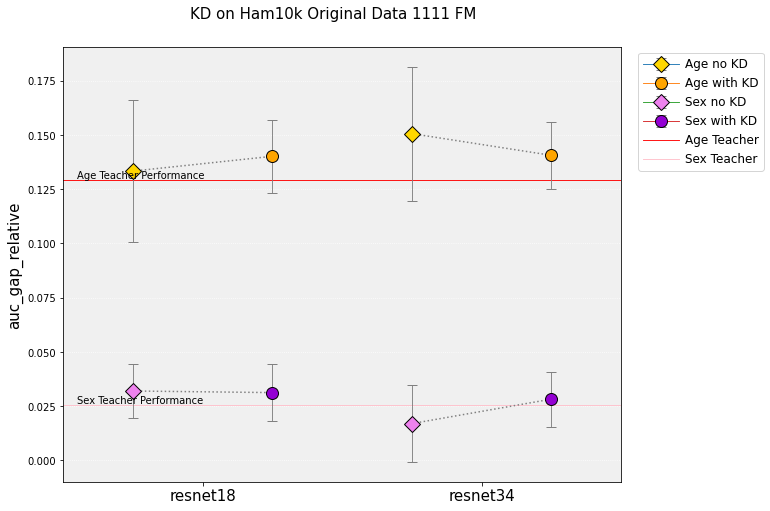

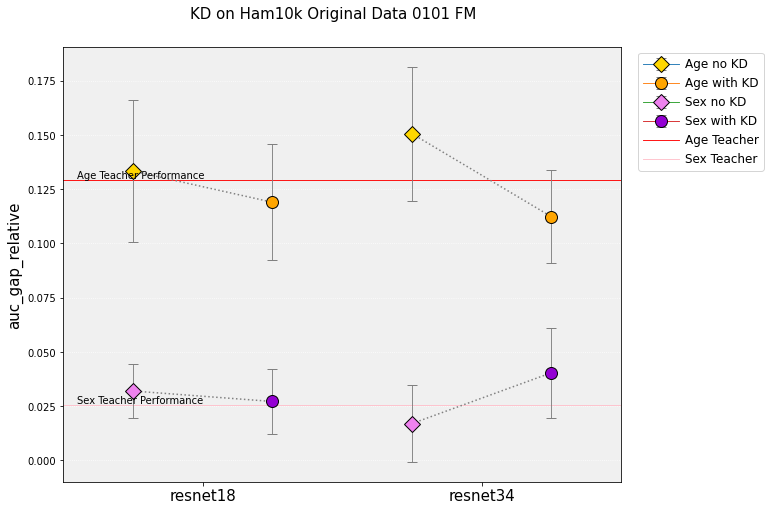

Ham10k Skewed Data


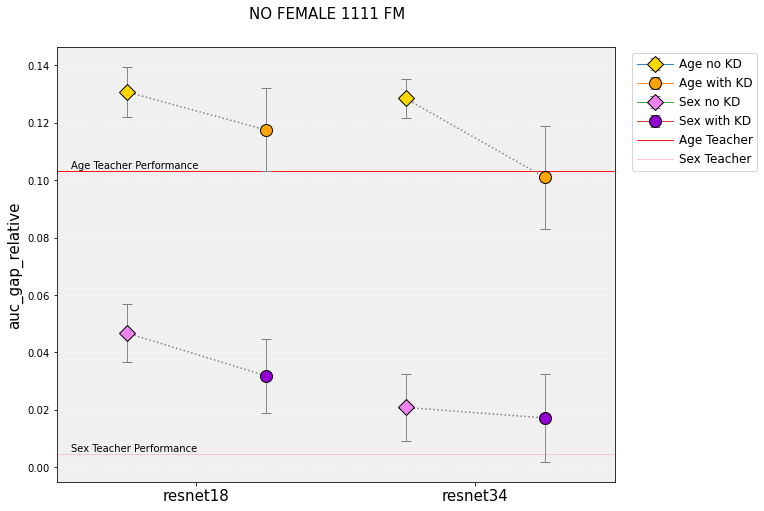

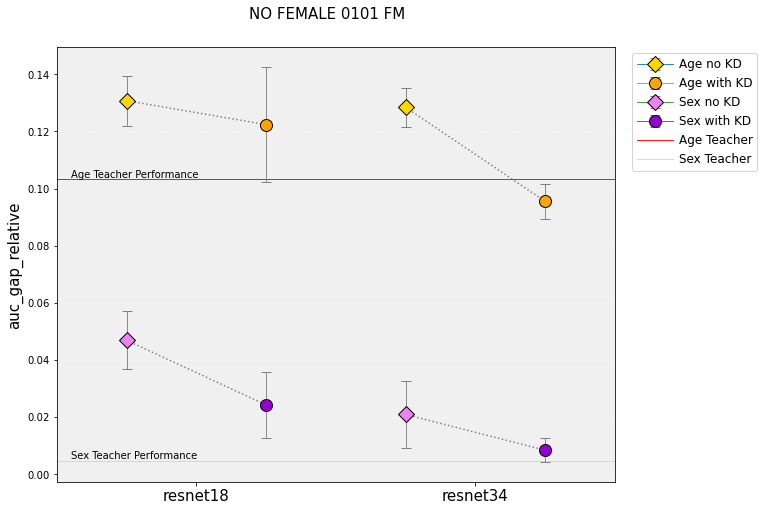

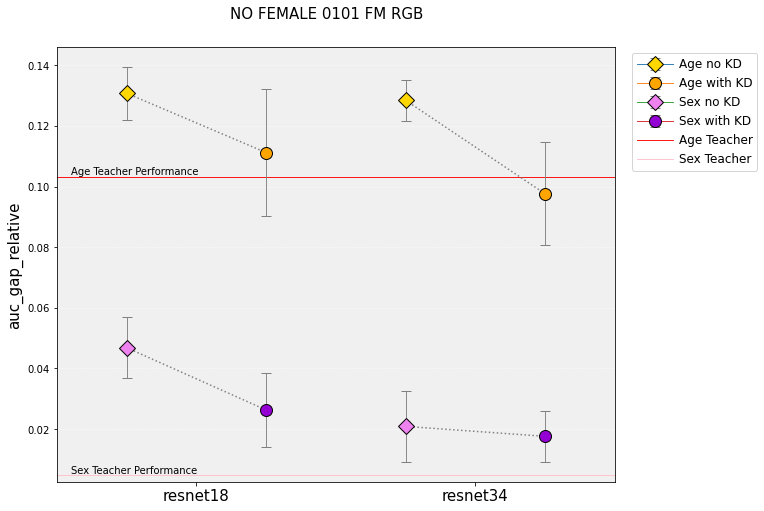

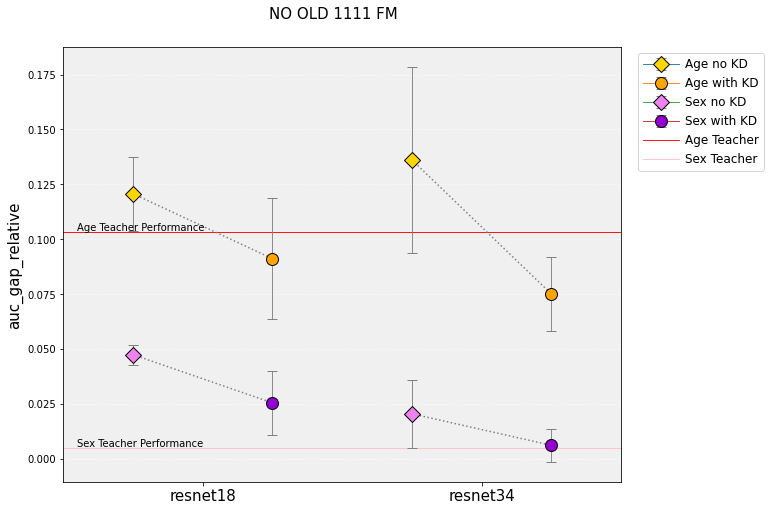

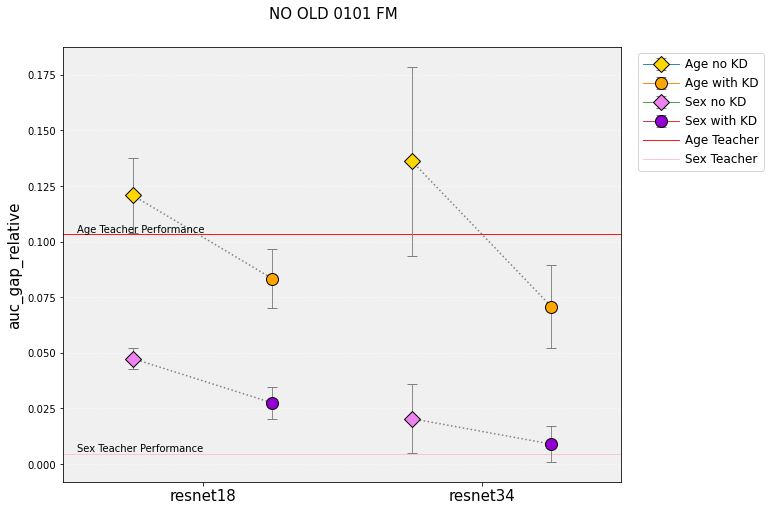

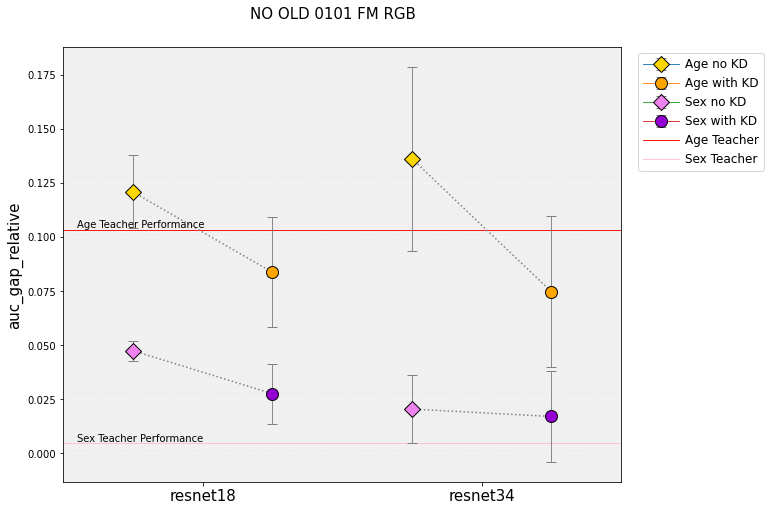

Ham10k Skewed Data CE+MSE+KL Loss


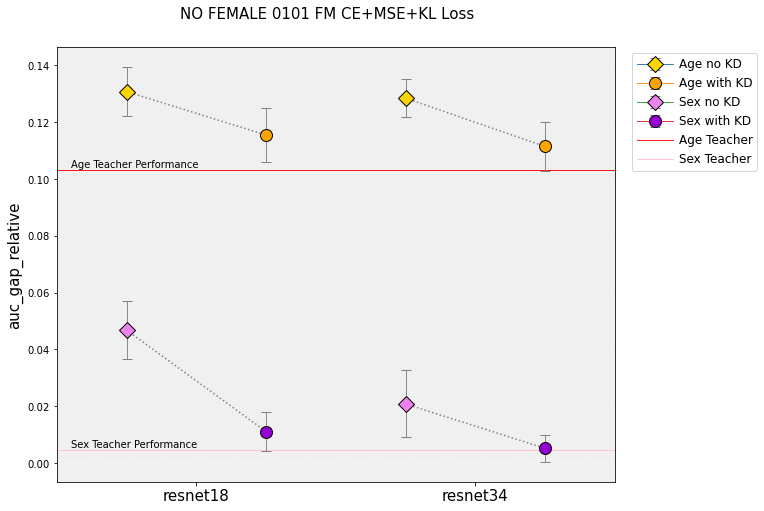

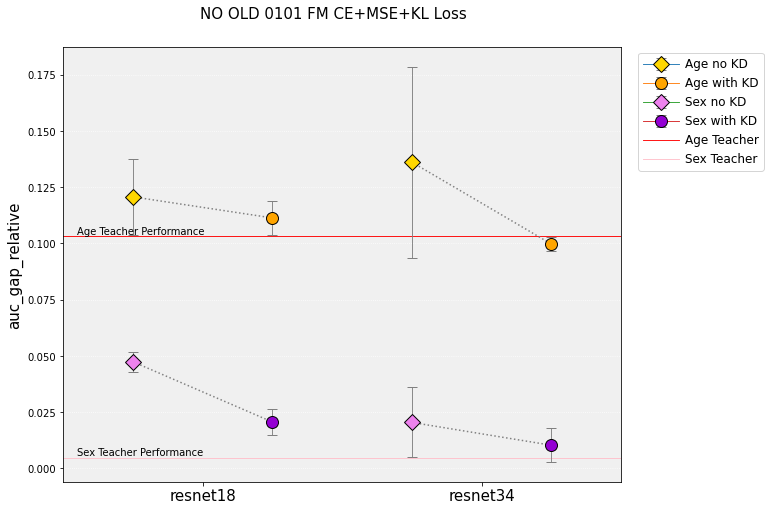

Ham10k CE MSE Equal Loss


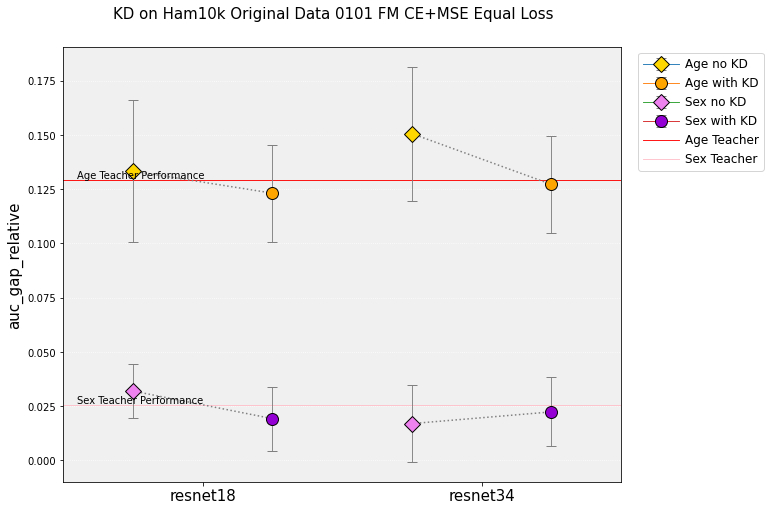

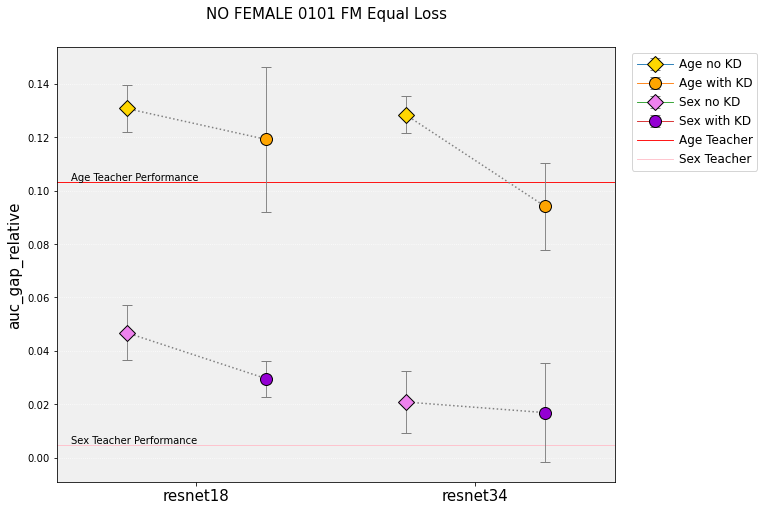

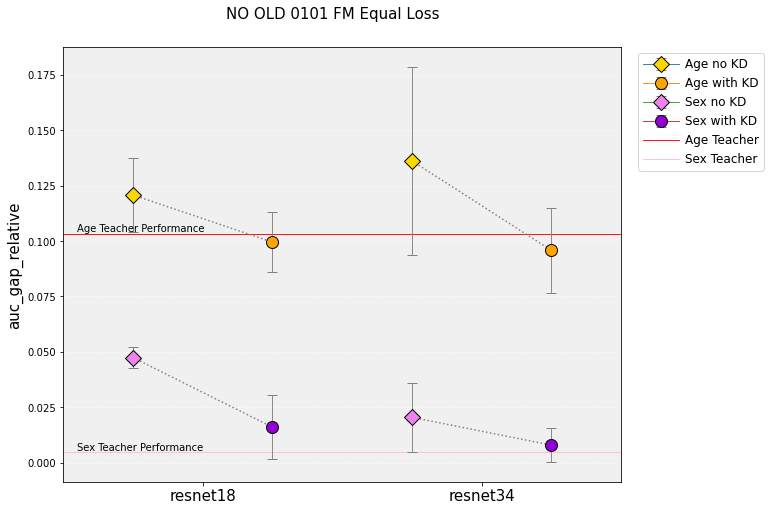

Ham10k Original Data CE+MSE+KL Loss


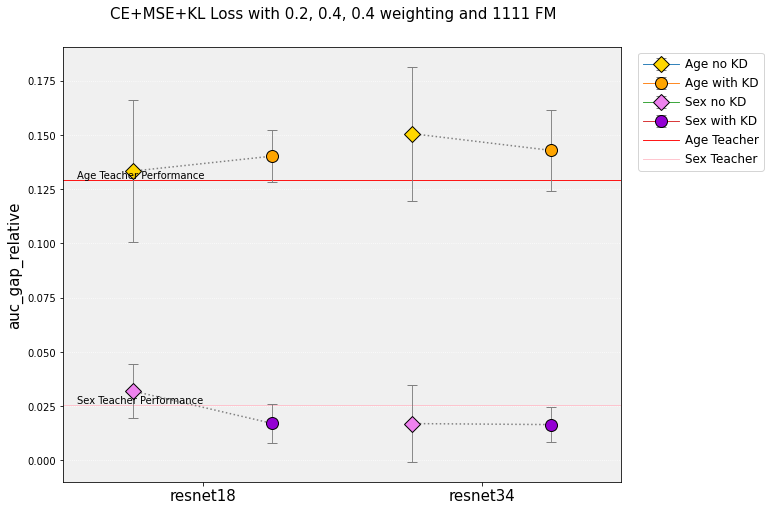

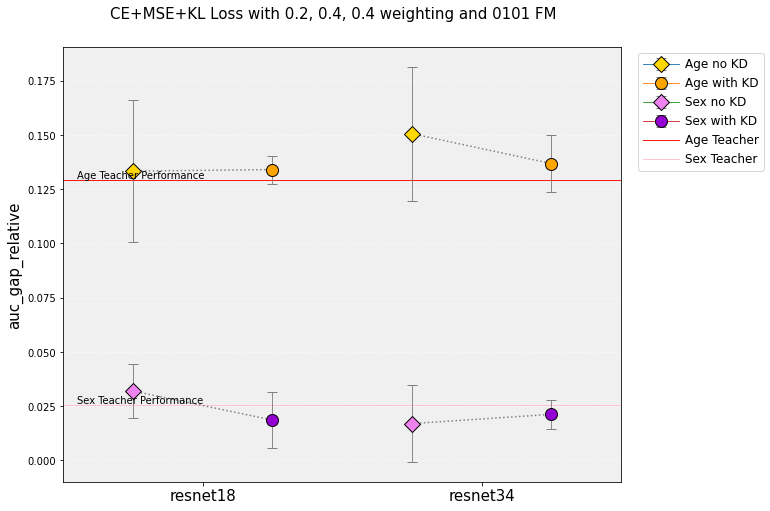

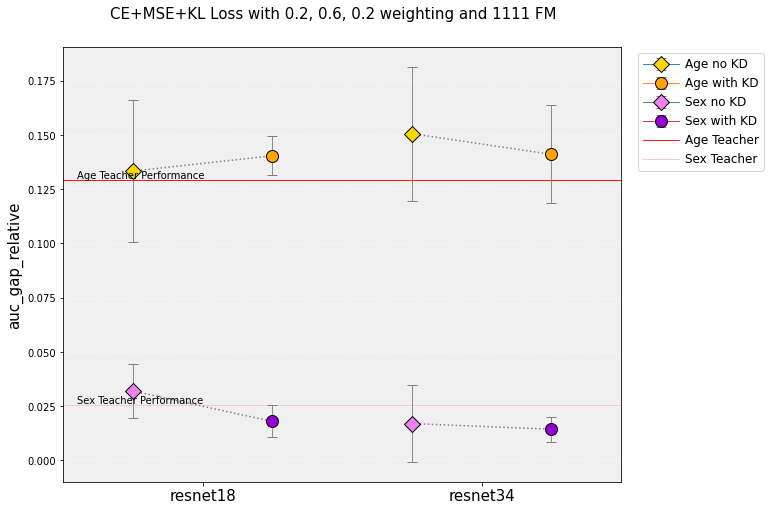

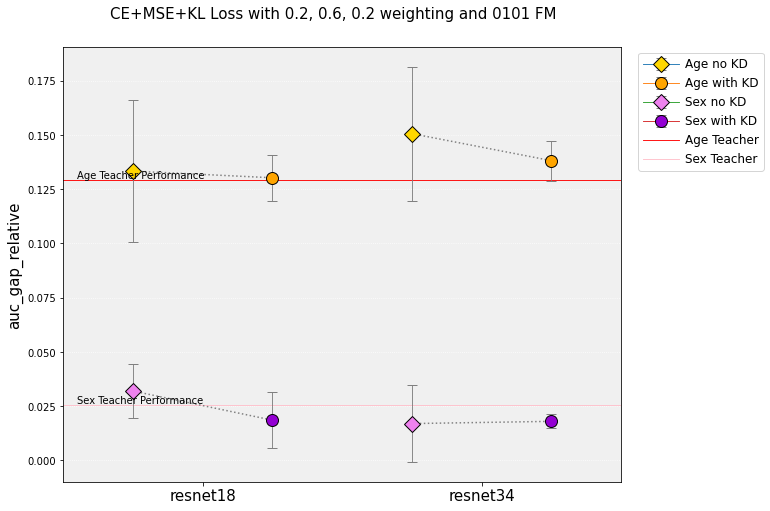

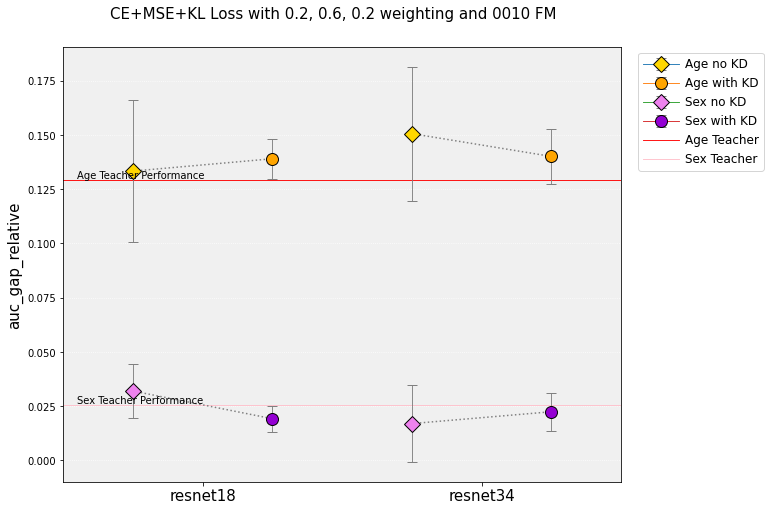

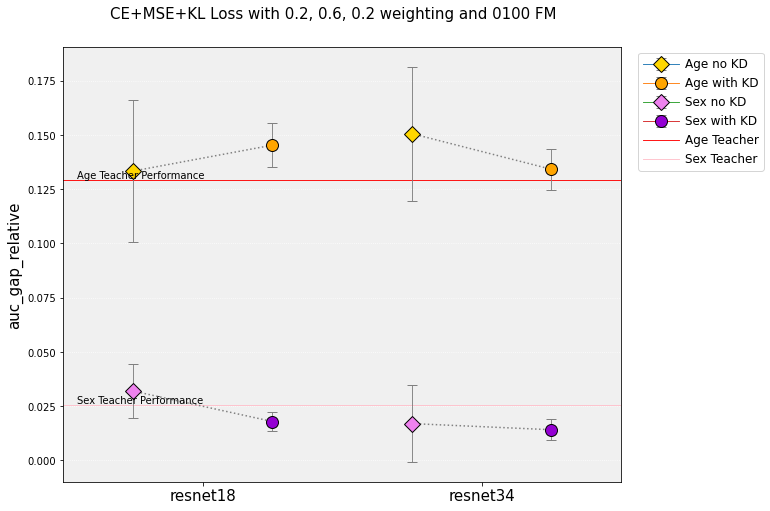

In [7]:
print('Ham10k Original Data')

kd_overall_model_subgroup_performance(
    original_df,
    fm1111_df,
    original_df,
    ['age', 'sex'],
    'r50-sam1-s44',
    'auc_gap_relative',
    title='KD on Ham10k Original Data 1111 FM',
)

kd_overall_model_subgroup_performance(
    original_df,
    fm0101_df,
    original_df,
    ['age', 'sex'],
    'r50-sam1-s44',
    'auc_gap_relative',
    title='KD on Ham10k Original Data 0101 FM',
)

print('Ham10k Skewed Data')

kd_overall_model_subgroup_performance(
    no_female_baseline,
    no_female_feature_1111,
    original_df,
    ['age', 'sex'],
    'r34-sam1-s46',
    'auc_gap_relative',
    title='NO FEMALE 1111 FM',
)

kd_overall_model_subgroup_performance(
    no_female_baseline,
    no_female_feature_0101,
    original_df,
    ['age', 'sex'],
    'r34-sam1-s46',
    'auc_gap_relative',
    title='NO FEMALE 0101 FM',
)

kd_overall_model_subgroup_performance(
    no_female_baseline,
    no_female_feature_rgb,
    original_df,
    ['age', 'sex'],
    'r34-sam1-s46',
    'auc_gap_relative',
    title='NO FEMALE 0101 FM RGB',
)

kd_overall_model_subgroup_performance(
    no_old_baseline,
    no_old_feature_1111,
    original_df,
    ['age', 'sex'],
    'r34-sam1-s46',
    'auc_gap_relative',
    title='NO OLD 1111 FM',
)

kd_overall_model_subgroup_performance(
    no_old_baseline,
    no_old_feature_0101,
    original_df,
    ['age', 'sex'],
    'r34-sam1-s46',
    'auc_gap_relative',
    title='NO OLD 0101 FM',
)

kd_overall_model_subgroup_performance(
    no_old_baseline,
    no_old_feature_rgb,
    original_df,
    ['age', 'sex'],
    'r34-sam1-s46',
    'auc_gap_relative',
    title='NO OLD 0101 FM RGB',
)

print('Ham10k Skewed Data CE+MSE+KL Loss')

kd_overall_model_subgroup_performance(
    no_female_baseline,
    no_female_ce_mse_kl_0101,
    original_df,
    ['age', 'sex'],
    'r34-sam1-s46',
    'auc_gap_relative',
    title='NO FEMALE 0101 FM CE+MSE+KL Loss',
)

kd_overall_model_subgroup_performance(
    no_old_baseline,
    no_old_ce_mse_kl_0101,
    original_df,
    ['age', 'sex'],
    'r34-sam1-s46',
    'auc_gap_relative',
    title='NO OLD 0101 FM CE+MSE+KL Loss',
)

print('Ham10k CE MSE Equal Loss')

kd_overall_model_subgroup_performance(
    original_df,
    equal_mse_ce,
    original_df,
    ['age', 'sex'],
    'r50-sam1-s44',
    'auc_gap_relative',
    title='KD on Ham10k Original Data 0101 FM CE+MSE Equal Loss',
)


kd_overall_model_subgroup_performance(
    no_female_baseline,
    equal_no_female,
    original_df,
    ['age', 'sex'],
    'r34-sam1-s46',
    'auc_gap_relative',
    title='NO FEMALE 0101 FM Equal Loss',
)

kd_overall_model_subgroup_performance(
    no_old_baseline,
    equal_no_old,
    original_df,
    ['age', 'sex'],
    'r34-sam1-s46',
    'auc_gap_relative',
    title='NO OLD 0101 FM Equal Loss',
)

print('Ham10k Original Data CE+MSE+KL Loss')

kd_overall_model_subgroup_performance(
    original_df,
    ce_mse_kl_1111,
    original_df,
    ['age', 'sex'],
    'r50-sam1-s44',
    'auc_gap_relative',
    title='CE+MSE+KL Loss with 0.2, 0.4, 0.4 weighting and 1111 FM',
)

kd_overall_model_subgroup_performance(
    original_df,
    ce_mse_kl_0101,
    original_df,
    ['age', 'sex'],
    'r50-sam1-s44',
    'auc_gap_relative',
    title='CE+MSE+KL Loss with 0.2, 0.4, 0.4 weighting and 0101 FM',
)

kd_overall_model_subgroup_performance(
    original_df,
    ce_mse_kl_2_1111,
    original_df,
    ['age', 'sex'],
    'r50-sam1-s44',
    'auc_gap_relative',
    title='CE+MSE+KL Loss with 0.2, 0.6, 0.2 weighting and 1111 FM',
)

kd_overall_model_subgroup_performance(
    original_df,
    ce_mse_kl_2_0101,
    original_df,
    ['age', 'sex'],
    'r50-sam1-s44',
    'auc_gap_relative',
    title='CE+MSE+KL Loss with 0.2, 0.6, 0.2 weighting and 0101 FM',
)

kd_overall_model_subgroup_performance(
    original_df,
    ce_mse_kl_2_0010,
    original_df,
    ['age', 'sex'],
    'r50-sam1-s44',
    'auc_gap_relative',
    title='CE+MSE+KL Loss with 0.2, 0.6, 0.2 weighting and 0010 FM',
)

kd_overall_model_subgroup_performance(
    original_df,
    ce_mse_kl_2_0100,
    original_df,
    ['age', 'sex'],
    'r50-sam1-s44',
    'auc_gap_relative',
    title='CE+MSE+KL Loss with 0.2, 0.6, 0.2 weighting and 0100 FM',
)

### Radar Chart

In [36]:
from typing import List
metric_names = {
    'auc': 'AUC',
    'age_auc_group_0': 'Age < 60 AUC',
    'age_auc_group_1': 'Age 60+ AUC',
    'sex_auc_group_0': 'Male AUC',
    'sex_auc_group_1': 'Female AUC',
    'avg_auc_gap': 'Avg AUC Gap',
    'age_auc_gap': 'Age AUC Gap',
    'sex_auc_gap': 'Sex AUC Gap',
    'age_eq_odds': 'Age Eq. Odds',
    'sex_eq_odds': 'Sex Eq. Odds',
}

def overall_radar_plot(
    resnet_df: pd.DataFrame, # baseline
    kd_df: pd.DataFrame,    # kd results
    original_df: pd.DataFrame, # df to take the teacher performance from
    metrics: List[str],
    teacher_id: str,
    student_model: str, # resnet18 or resnet34
    title: str = 'title',
    is_performance: bool = True,
):
    # get the teacher performance
    teacher_df = original_df[original_df['model_id'] == teacher_id]
    teacher_df = teacher_df[metrics]
    teacher_df = teacher_df.rename(columns=metric_names)
    teacher_df = teacher_df.melt(var_name='metric', value_name='value')

    # get the average baseline performance by model
    student_baseline = resnet_df[resnet_df['model_name'] == student_model]
    student_baseline = student_baseline[metrics]
    student_baseline = student_baseline.rename(columns=metric_names)
    student_baseline = student_baseline.mean().to_frame().T
    student_baseline = student_baseline.melt(var_name='metric', value_name='value')
    
    # get the average kd performance by model
    student_kd = kd_df[(kd_df['model_name'] == student_model) & (kd_df['teacher_id'] == teacher_id)]
    student_kd = student_kd[metrics]
    student_kd = student_kd.rename(columns=metric_names)
    student_kd = student_kd.mean().to_frame().T
    student_kd = student_kd.melt(var_name='metric', value_name='value')

    # Add last element to create a circular effect
    teacher_df = teacher_df.append(teacher_df.iloc[0], ignore_index=True) 
    student_baseline = student_baseline.append(student_baseline.iloc[0], ignore_index=True) 
    student_kd = student_kd.append(student_kd.iloc[0], ignore_index=True) 

    fig = go.Figure()
    fig = px.line_polar(start_angle=90)

    # PERFORMANCE
    if is_performance:
        fig.add_trace(go.Scatterpolar(
            r=teacher_df['value'],
            theta=teacher_df['metric'],
            name='Teacher',
        ))
        fig.add_trace(go.Scatterpolar(
            r=student_kd['value'],
            theta=student_kd['metric'],
            name=f'{student_model.capitalize()} w/ KD',
        ))
        fig.add_trace(go.Scatterpolar(
            r=student_baseline['value'],
            theta=student_baseline['metric'],
            name=f'{student_model.capitalize()} w/o KD',
        ))
        fig.update_layout(
        width=800,  # Set the width of the plot (in pixels)
        height=600,  # Set the height of the plot (in pixels)
        title={
            'text': title,
            'x': 0.5,  # Align the title in the center
            'y': 1.0,  # Adjust the vertical position of the title
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {'size': 14}  # Adjust the font size of the title
        },
        polar=dict(
            radialaxis=dict(
            visible=True,
            range=[0.7, 1.0],
            tickvals=list(np.arange(0.75, 1.0, 0.05)),  # Specify the position where ticks appear
            ),
        ),
            showlegend=True,
        )

    # FAIRNESS
    else:
        fig.add_trace(go.Scatterpolar(
            r=student_baseline['value'],
            theta=student_baseline['metric'],
            name=f'{student_model.capitalize()} w/o KD',
            line_color='#AB63FA'
        ))
        fig.add_trace(go.Scatterpolar(
            r=student_kd['value'],
            theta=student_kd['metric'],
            name=f'{student_model.capitalize()} w/ KD',
            line_color='#00CC96'
        ))
        fig.add_trace(go.Scatterpolar(
            r=teacher_df['value'],
            theta=teacher_df['metric'],
            name='Teacher',
            line_color='#EF553B'
        ))
        fig.update_layout(
        width=800,  # Set the width of the plot (in pixels)
        height=600,  # Set the height of the plot (in pixels)
        title={
            'text': title,
            'x': 0.5,  # Align the title in the center
            'y': 1.0,  # Adjust the vertical position of the title
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {'size': 14}  # Adjust the font size of the title
        },
        polar=dict(
            radialaxis=dict(
            visible=True,
            # range=[0.0, 0.15],
            # tickvals=list(np.arange(0.75, 1.0, 0.05)),  # Specify the position where ticks appear
            ),
        ),
            showlegend=True,
        )

    fig.update_traces(fill='toself')
    fig.show()


In [37]:
# overall_radar_plot(
#     original_df,
#     feature_kd_ham10k,
#     original_df,
#     ['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1'],
#     'r50-sam1-s44',
#     student_model='resnet18',
#     title='Mean ResNet18 metrics with and without KD comapred to ResNet34 teacher for NO FEMALE dataset',
#     is_performance=True
# )

# overall_radar_plot(
#     original_df,
#     feature_kd_ham10k,
#     original_df,
#     ['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1'],
#     'r50-sam1-s44',
#     student_model='resnet34',
#     title='Mean ResNet18 metrics with and without KD comapred to ResNet34 teacher for NO FEMALE dataset',
#     is_performance=True
# )
